In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# load normalized data and true labels
scaled_data = pd.read_csv('/scaled_top_100.csv', index_col=0)
labels = pd.read_csv('/labels_top_100.csv')

# encode categorical labels to numerical codes
labels = labels['Response'].values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Label Map:")
for encoded_value, original_label in enumerate(label_encoder.classes_):
    print(f"{encoded_value}: {original_label}")

Label Map:
0: N
1: R


In [3]:
# fit PCA to data
pca = PCA(n_components=15)
pca.fit_transform(scaled_data)

array([[22.86929081, -8.30759892, -0.19908986, ..., -0.17010831,
         0.83565787,  0.94724966],
       [14.1125468 , -0.41133011,  0.36591593, ..., -0.98623996,
        -2.24516854, -0.84004967],
       [15.47079095,  2.29912806, -2.42759131, ...,  2.91187416,
         2.55474634,  0.98779698],
       ...,
       [ 1.39835858, -2.06862253, -0.36285342, ...,  0.26379311,
         1.58433463,  0.32207212],
       [-0.23767943,  1.13895796,  0.31778641, ...,  0.29433565,
         0.51885142,  0.06652856],
       [-2.99295652, -4.54960877, -0.77387314, ...,  0.10521387,
         1.10558832, -0.45349346]])

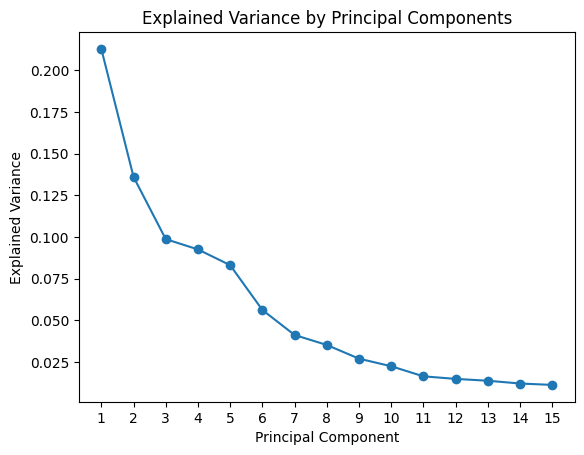

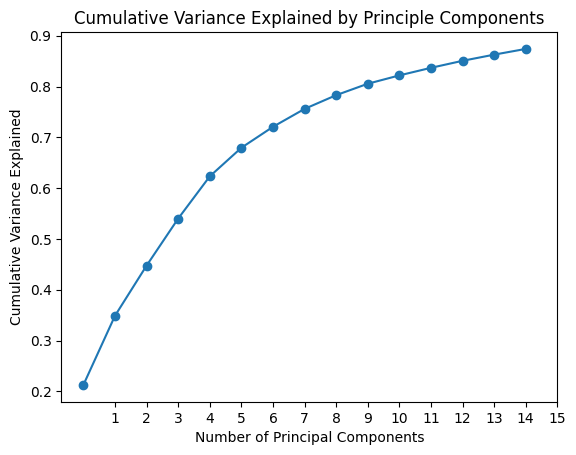

In [4]:
# use elbow method on variance explained to select optimal number of principal components
explained_variance = pca.explained_variance_ratio_

# plot explained variance against principal component
plt.plot(range(1, len(explained_variance) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

# also check cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Variance Explained by Principle Components')
plt.xlabel('Number of Principal Components')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.ylabel('Cumulative Variance Explained') ;

In [5]:
# 2 principal components seems to be optimal
pca2 = PCA(n_components=2)
PCAreduced_data = pca2.fit_transform(scaled_data)

In [6]:
# Get the loadings (coefficients) for the first two principal components
loadings = pca2.components_[:2]
# Get the absolute values of the loadings
abs_loadings = np.abs(loadings)
# Find the indices of top features for each principal component in descending order
top_features_indices = np.argsort(abs_loadings, axis=1)[:, ::-1]
# Make the column headers in scaled_data as a list
genes = list(scaled_data.columns)
# Get the names of features corresponding to the top indices
top_features = [genes[idx] for idx in top_features_indices.flatten()]
print(top_features)

['63', '8', '5', '18', '14', '2', '17', '21', '15', '3', '9', '6', '4', '25', '33', '11', '28', '36', '60', '39', '46', '20', '0', '82', '27', '75', '32', '93', '37', '69', '7', '59', '97', '30', '91', '45', '16', '67', '88', '13', '58', '1', '23', '51', '72', '77', '34', '56', '98', '83', '80', '64', '96', '90', '89', '84', '66', '68', '78', '31', '85', '65', '79', '40', '94', '55', '10', '61', '35', '71', '41', '86', '70', '92', '12', '19', '22', '95', '99', '26', '29', '53', '54', '76', '81', '42', '50', '87', '52', '24', '49', '43', '57', '73', '38', '62', '48', '44', '74', '47', '98', '34', '58', '66', '80', '67', '59', '96', '7', '56', '37', '65', '91', '93', '69', '97', '45', '75', '32', '90', '40', '83', '13', '79', '41', '89', '16', '61', '84', '23', '17', '3', '11', '8', '31', '2', '15', '5', '95', '6', '71', '63', '87', '4', '1', '18', '55', '9', '48', '25', '14', '28', '43', '44', '76', '57', '74', '68', '33', '54', '73', '77', '88', '81', '42', '19', '53', '21', '46', '38'

In [7]:
# To find the gene names of the top contributing genes of the PCA
log_2_data = pd.read_csv('/log2_top_100.csv')
Gene1 = log_2_data.columns[63+1]
print('Gene1:', Gene1)
Gene2 = log_2_data.columns[8+1]
print('Gene2:',Gene2)

Gene1: MTATP6P1
Gene2: MT-ND4


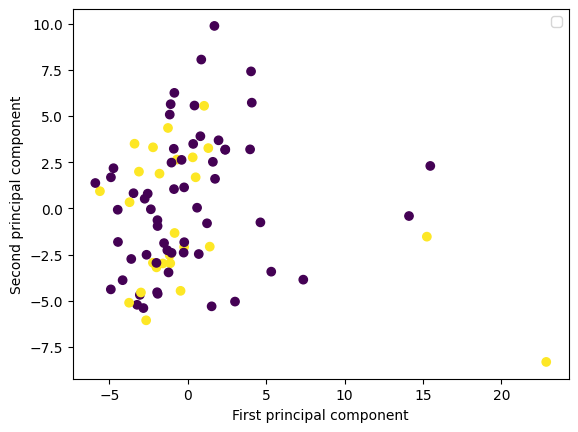

In [8]:
plt.scatter(PCAreduced_data[:, 0], PCAreduced_data[:, 1], c=labels_encoded)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()
plt.show()

In [27]:
# Train a logistic regression model using the top 2 PCAs before optimizing hyperparameters
X_train, X_test, y_train, y_test = train_test_split(PCAreduced_data, labels_encoded, test_size = 0.3, random_state=1210)
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_train)
training_accuracy = accuracy_score(y_pred, y_train)
y_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test)
print("Training accuracy before hyperparameter optimization:", training_accuracy)
print("Test set accuracy before hyperparameter optimization:", test_accuracy)

Training accuracy before hyperparameter optimization: 0.7241379310344828
Test set accuracy before hyperparameter optimization: 0.6538461538461539


In [28]:
# find the best hyperparameters for an L1 regularized LogReg model
hyperparameters = {
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(LogisticRegression(penalty="l1"), hyperparameters,  cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best hyperparameters: {'C': 0.1, 'max_iter': 1000, 'solver': 'saga'}


In [29]:
# Train a logistic regression model using the top 2 PCAs after optimizing hyperparameters
y_pred = best_model.predict(X_train)
training_accuracy = accuracy_score(y_pred, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test)

print("Training accuracy after hyperparameter optimization:", training_accuracy)
print("Test set accuracy after hyperparameter optimization:", test_accuracy)

Training accuracy after hyperparameter optimization: 0.7068965517241379
Test set accuracy after hyperparameter optimization: 0.6538461538461539
